In [1]:
import json
import sys
import warnings
import os

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# from labellines import labelLines

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the working directory to the opt directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir + "/opt")

from data_process import DataProcessor
from ev_opt import EV_Opt
from ev_eval import EVChargerEquityEvaluation

output_dir = "../output/ev_opt_run_exfactor"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# set font arial

matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["font.sans-serif"] = "Arial"

In [2]:
# read config
with open(os.path.join(output_dir, "kwargs_lst.json"), "r") as f:
    config = json.load(f)

k = 4
equity_indicator_list = config["equity_indicator_list"]
demographic_group_list = config["demographic_group_list"]
disparity_index_list = config["disparity_index_list"]
max_add_capacity_list = config["max_add_capacity_list"]
multi_obj_setting = np.array(config["multi_obj_setting"])

data_processor = DataProcessor()
# set demographic partition based on quantiles
kwargs = {
    "income_bins": k,
    "mud_bins": k,
    "employment_bins": k,
}

data_processor = DataProcessor()
# set demographic partition based on quantiles
kwargs = {
    "income_bins": k,
    "mud_bins": k,
    "employment_bins": k,
}
# three dfs respectively: demographic data, commute matrix, and VKT flow matrix
df1, df2, df3 = data_processor.process_demo_data(**kwargs)

# set crs to 3857 (from spherical to flat)
df1.crs = "EPSG:4326"
df1 = df1.to_crs("EPSG:3857")

In [3]:
"""
# read all npz files in the output directory and combine
npz_files = [f for f in os.listdir(output_dir) if f.endswith(".npz")]
data_list = []
for npz_file in npz_files:
    npz_path = os.path.join(output_dir, npz_file)
    data = np.load(npz_path)
    # read from name
    # ex_factor between last _ and .npz
    ex_factor = float(npz_file.split("_")[-1].replace(".npz", ""))
    multi_obj_bet_weight = float(npz_file.split("_")[-2])
    max_add_capacity = float(npz_file.split("_")[-3])
    equity_indicator = "_".join(npz_file.split("_")[2:6])

    # Extract arrays from the npz file
    charger_capacity_wp = data["arr_0"]
    equivalent_char_capacity = data["arr_1"]
    equity_indicator_xi = data["arr_2"]
    objective_value = data["arr_3"]
    obj_sol_within = data["arr_4"]
    obj_sol_between = data["arr_5"]

    # Append to the list
    data_list.append(
        {
            "equity_indicator": equity_indicator,
            "demographic_group": demographic_group_list[0],
            "disparity_index": disparity_index_list[0],
            "max_add_capacity": max_add_capacity,
            "weight_within": 1 - multi_obj_bet_weight,
            "weight_between": multi_obj_bet_weight,
            "ex_factor": ex_factor,
            "charger_capacity_wp": charger_capacity_wp,
            "equivalent_char_capacity": equivalent_char_capacity,
            "equity_indicator_xi": equity_indicator_xi,
            "objective_value": objective_value,
            "obj_sol_within": obj_sol_within,
            "obj_sol_between": obj_sol_between,
        }
    )

df_result_val = pd.DataFrame(data_list)

df_result_val["obj_sol_between"] = df_result_val["obj_sol_between"].astype(float)
df_result_val["obj_sol_within"] = df_result_val["obj_sol_within"].astype(float)
df_result_val["objective_value"] = df_result_val["objective_value"].astype(float)

df_result_val.to_csv(
    os.path.join(output_dir, "df_result_val.csv"), index=False
)
"""

'\n# read all npz files in the output directory and combine\nnpz_files = [f for f in os.listdir(output_dir) if f.endswith(".npz")]\ndata_list = []\nfor npz_file in npz_files:\n    npz_path = os.path.join(output_dir, npz_file)\n    data = np.load(npz_path)\n    # read from name\n    # ex_factor between last _ and .npz\n    ex_factor = float(npz_file.split("_")[-1].replace(".npz", ""))\n    multi_obj_bet_weight = float(npz_file.split("_")[-2])\n    max_add_capacity = float(npz_file.split("_")[-3])\n    equity_indicator = "_".join(npz_file.split("_")[2:6])\n\n    # Extract arrays from the npz file\n    charger_capacity_wp = data["arr_0"]\n    equivalent_char_capacity = data["arr_1"]\n    equity_indicator_xi = data["arr_2"]\n    objective_value = data["arr_3"]\n    obj_sol_within = data["arr_4"]\n    obj_sol_between = data["arr_5"]\n\n    # Append to the list\n    data_list.append(\n        {\n            "equity_indicator": equity_indicator,\n            "demographic_group": demographic_g

In [4]:
df_result_val = pd.read_csv(
    os.path.join(output_dir, "df_result_val.csv")
)

In [5]:
# by sequence of following indicators
indicator_order = [
    "char_capacity_per_capita",
    "char_capacity_per_car",
    "char_capacity_per_VKT",
]
df_result_val["equity_indicator"] = pd.Categorical(
    df_result_val["equity_indicator"],
    categories=indicator_order,
    ordered=True,
)
# sort by equity indicator
df_result_val.sort_values(["ex_factor", "equity_indicator", "demographic_group", "max_add_capacity", "weight_within", "weight_between"], inplace=True)

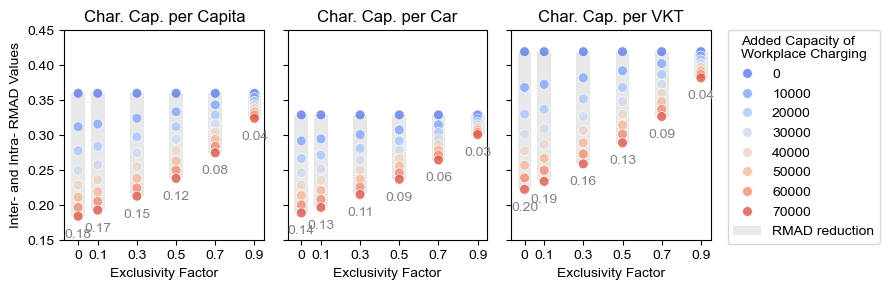

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Ensure the columns are numeric
df_result_val["objective_value"] = df_result_val["objective_value"].astype(float)
df_result_val["ex_factor"] = df_result_val["ex_factor"].astype(float)

# Get unique equity indicators
equity_indicators = df_result_val["equity_indicator"].unique()
legend_ticks = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000]

# Define a discrete colormap with 8 colors
palette = sns.color_palette("coolwarm", n_colors=len(legend_ticks))
color_mapping = dict(zip(legend_ticks, palette))  # Explicit mapping of values to colors

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)
axes = axes.flatten()
# fig.delaxes(axes[3])

title_labels = ["Char. Cap. per Capita", "Char. Cap. per Car", "Char. Cap. per VKT"]

# Iterate over each equity indicator and plot
for i, equity in enumerate(equity_indicators):
    ax = axes[i]
    subset = df_result_val[df_result_val["equity_indicator"] == equity]

    disparity_0 = subset.groupby("ex_factor")["objective_value"].max() 
    disparity_70k = subset.groupby("ex_factor")["objective_value"].min()
    disparity_0 = disparity_0.reset_index()
    disparity_70k = disparity_70k.reset_index()
    disparity_reduection = disparity_70k.copy()
    disparity_reduection["obj_reduction"] = disparity_0["objective_value"] - disparity_70k["objective_value"]

    disparity_0.rename(columns={"objective_value": "objective_value_0"}, inplace=True)
    disparity_70k.rename(columns={"objective_value": "objective_value_70k"}, inplace=True)
    disparity_df = pd.merge(disparity_0, disparity_70k, on="ex_factor")    
    # Plot bar plot
    ax.bar(
        disparity_df["ex_factor"],  # Use numeric x values
        disparity_df["objective_value_0"],
        color="lightgrey",
        edgecolor="lightgrey",
        width=0.07,  # Adjust width to fit numeric scale
        alpha=0.5,
        linewidth=0.01,
        label="RMAD reduction",
    )
    ax.bar(
        disparity_df["ex_factor"],
        disparity_df["objective_value_70k"],
        color="white",
        edgecolor="white",
        width=0.07,
        linewidth=0.02,
        alpha=1,
    )

    # add reduction as texts
    for j, row in disparity_reduection.iterrows():
        ax.text(
            row["ex_factor"],
            row["objective_value"] - 0.035,
            f"{row['obj_reduction']:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='grey',
        )

    # Scatter plot
    sns.scatterplot(
        data=subset,
        x="ex_factor",
        y="objective_value",
        hue="max_add_capacity",
        ax=ax,
        palette=color_mapping,
        s=50,
        alpha=0.8,
    )


    # Customize each subplot
    ax.set_title(title_labels[i])
    ax.set_xlabel("Exclusivity Factor")
    ax.set_ylabel("Inter- and Intra- RMAD Values" if i == 0 else "")
    ax.grid(False) # linestyle='-', alpha=0.5
    ax.get_legend().remove()  # Remove legend from individual subplots

# Set x-ticks
# Set x-ticks
xticks = [0] + list(np.round(np.arange(0.1, 1, 0.2), 2))  # Ensure precision and keep 0 as an integer
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([str(tick) if tick != 0 else "0" for tick in xticks])  # Format labels to keep 0 as "0"
axes[0].set_yticks(np.arange(0.15, 0.45, 0.05))
axes[0].set_xlim(-0.07, 0.95)
axes[0].set_ylim(0.15, 0.45)

# axes[1].set_xticks(np.arange(0, 1, 0.1))
# axes[1].set_xlim(-0.07, 0.95)
# axes[2].set_xticks(np.arange(0, 1, 0.1))
# axes[2].set_xlim(-0.07, 0.95)
# Add a common legend
handles, labels = axes[2].get_legend_handles_labels()
labels[:-1] = [int(float(label)) for label in labels[:-1]]  # Convert to float first, then to int
axes[2].legend(
    handles=handles,
    labels= labels[:9],#[f"{tick:,}" for tick in legend_ticks],  # Format labels with commas
    title="Added Capacity of\nWorkplace Charging",
    bbox_to_anchor=(1.05, -0.05),
    loc='lower left',
    # ncol = 2,
)
# mora handels: 
handles.append(plt.Line2D([0], [0], color='lightgrey', lw=4, label='RMAD Reduction'))
labels.append('RMAD Reduction')
# remove all axes in axes[3]
# axes[3].axis('off')  # Hide the axis for the last subplot
# Adjust layout
plt.tight_layout()

plt.savefig("../output/ev_opt_run_exfactor/fig_rmad_reduction.png", dpi=300, bbox_inches='tight')

In [7]:
disparity_reduection

,ex_factor,objective_value,obj_reduction
0,0.0,0.222831,0.196784
1,0.1,0.234186,0.185429
2,0.3,0.259240,0.160375
3,0.5,0.289331,0.130284
4,0.7,0.326956,0.092659
5,0.9,0.382206,0.037408


In [8]:
df_result_val = df_result_val.reset_index(drop=True)
df_result_val
# objective value of different ex_factor

df_result_val["objective_value"] = df_result_val["objective_value"].astype(float)
df_result_val["ex_factor"] = df_result_val["ex_factor"].astype(float)

correlation = df_result_val["objective_value"].corr(df_result_val["ex_factor"])
print(f"Correlation between objective_value and ex_factor: {correlation}")


Correlation between objective_value and ex_factor: 0.501309603577271


/var/folders/0z/wc3521k12b5g7pwr410swq240000gq/T/ipykernel_82108/252636833.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_plot00["equity_indicator"] = pd.Categorical(
/var/folders/0z/wc3521k12b5g7pwr410swq240000gq/T/ipykernel_82108/252636833.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_plot00["equity_indicator"] = pd.Categorical(
/var/folders/0z/wc3521k12b5g7pwr410swq240000gq/T/ipykernel_82108/252636833.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

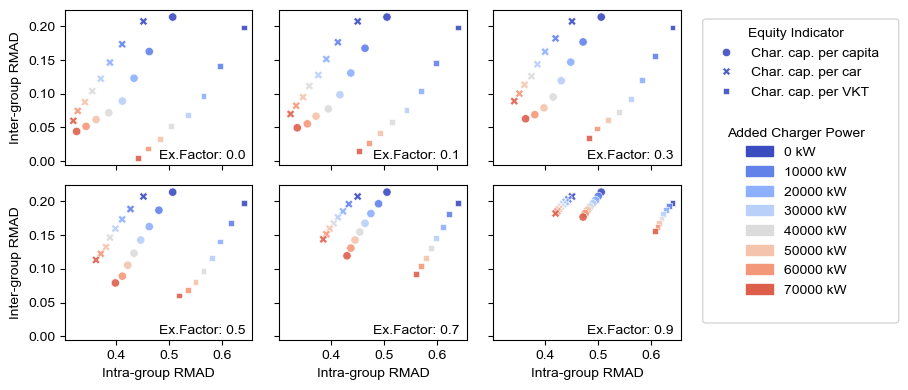

In [9]:
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches


df_temp_plot = df_result_val.copy()
df_temp_plot = df_temp_plot[df_temp_plot["weight_within"] > 0][df_temp_plot["weight_between"] > 0]
coolwarm = sns.color_palette("coolwarm", as_cmap=True)

fig, ax = plt.subplots(2, 3, figsize=(7, 4), sharex=True, sharey=True)
ax = ax.flatten()
demographic_group_list_name = ["Income Level", "MUD Rate", "Employment\nRate", "Major Ethnicity"]
ex_factor_list = sorted(df_temp_plot["ex_factor"].unique())
ex_factor_list_name = ["Ex.Factor: " + str(ex_factor) for ex_factor in ex_factor_list]

for ex_factor in ex_factor_list:
    i = list(ex_factor_list).index(ex_factor)
    df_temp_plot_one_demo = df_temp_plot[df_temp_plot["ex_factor"] == ex_factor]

    max_add_capacity = 0

    df_temp_plot00 = df_temp_plot_one_demo[df_temp_plot_one_demo["max_add_capacity"] == max_add_capacity]
    df_temp_plot00["equity_indicator"] = pd.Categorical(
    df_temp_plot00["equity_indicator"], categories=indicator_order, ordered=True
)

    # sns.scatterplot(
    #         data=df_temp_plot00,
    #         x="obj_sol_within",
    #         y="obj_sol_between",
    #         # style="equity_indicator",
    #         color=coolwarm(max_add_capacity/80000),
    #         sizes=(50, 200),
    #         palette="coolwarm",
    #         alpha=0.9,
    #         ax=ax[i],
    #         # edgecolor="lightgrey",
    #     )

    for max_add_capacity in max_add_capacity_list:
        df_temp_plot00 = df_temp_plot_one_demo[df_temp_plot_one_demo["max_add_capacity"] == max_add_capacity]
        # df_temp_plot00.obj_sol_within = df_temp_plot00.obj_sol_within.round(3)
        # df_temp_plot00.obj_sol_between = df_temp_plot00.obj_sol_between.round(3)
        # scatterplot
        sns.scatterplot(
            data=df_temp_plot00,
            x="obj_sol_within",
            y="obj_sol_between",
            style="equity_indicator",
            color=coolwarm(max_add_capacity / 80000),
            sizes=(50, 200),
            palette="coolwarm",
            alpha=0.9,
            ax=ax[i],
            # edgecolor="lightgrey",
        )

    ax[i].legend([], [], frameon=False)
    ax[i].set_xlabel("Intra-group RMAD")
    ax[i].set_ylabel("Inter-group RMAD")

ax[0].text(
    0.5,
    0.1,
    ex_factor_list_name[0],
    transform=ax[0].transAxes,
    fontsize=10,
    verticalalignment="top",
    color="black",
)
ax[1].text(0.5, 0.1, ex_factor_list_name[1], transform=ax[1].transAxes, fontsize=10, verticalalignment="top")
ax[2].text(0.5, 0.1, ex_factor_list_name[2], transform=ax[2].transAxes, fontsize=10, verticalalignment="top")
ax[3].text(0.5, 0.1, ex_factor_list_name[3], transform=ax[3].transAxes, fontsize=10, verticalalignment="top")
ax[4].text(0.5, 0.1, ex_factor_list_name[4], transform=ax[4].transAxes, fontsize=10, verticalalignment="top")
ax[5].text(0.5, 0.1, ex_factor_list_name[5], transform=ax[5].transAxes, fontsize=10, verticalalignment="top")

fig.subplots_adjust(hspace=0.5)
handles, labels = ax[0].get_legend_handles_labels()
labels = ["Char. cap. per capita", "Char. cap. per car", "Char. cap. per VKT"]
# set legend handles color to be black
for handle in handles:
    handle.set_color("black")
# create max_add_capacity legend
patchList = []
for i in range(0, len(max_add_capacity_list), 1):
    max_add_capacity = max_add_capacity_list[i]
    data_key = mpatches.Patch(color=coolwarm(max_add_capacity / 80000), label=str(max_add_capacity) + " kW")
    patchList.append(data_key)
# remove box around legend

fig.legend(
    handles[:3],
    labels[:3],
    title="Equity Indicator",
    ncols=1,
    loc="upper right",
    bbox_to_anchor=(1.27, 0.95),
    frameon=False,
)
fig.legend(
    handles=patchList, title="Added Charger Power", loc="upper right", bbox_to_anchor=(1.25, 0.7), ncol=1, frameon=False
)
# Manually draw a box around the legend
box = FancyBboxPatch(
    (1.0, 0.18),
    0.28,
    0.76,
    boxstyle="round,pad=0,rounding_size=0.006",
    fill=False,
    edgecolor="gray",
    linewidth=0.8,
    alpha=0.4,
    transform=fig.transFigure,
    figure=fig,
)
fig.patches.append(box)

plt.tight_layout()
plt.savefig(f"{output_dir}/inter_intra_RMAD_change_ex_factor.pdf", bbox_inches="tight", dpi=300)